https://towardsdatascience.com/nlp-with-python-knowledge-graph-12b93146a458

In [1]:
## for data
import pandas as pd  #1.1.5
import numpy as np  #1.21.0

## for plotting
import matplotlib.pyplot as plt  #3.3.2

## for text
#import wikipediaapi  #0.5.8
#import nltk  #3.8.1
import re   

## for nlp
import spacy  #3.5.0
from spacy import displacy
#import textacy  #0.12.0

## for graph
import networkx as nx  #3.0 (also pygraphviz==1.10)

## for timeline
#import dateparser #1.1.7

In [2]:
nlp = spacy.load("en_core_web_md")

In [3]:
txt = """ Peter travels to London.
        Frank likes Berlin.
        Marta goes to Paris.
        Frank visits Madrid.
        Kepa goes to Bilbao.
        Hellen likes Berlin."""
doc = nlp(txt)

In [4]:
# from text to a list of sentences
lst_docs = [sent for sent in doc.sents]
print("tot sentences:", len(lst_docs))
print(lst_docs)


tot sentences: 6
[ Peter travels to London.
        , Frank likes Berlin.
        , Marta goes to Paris.
        , Frank visits Madrid.
        , Kepa goes to Bilbao.
        , Hellen likes Berlin.]


Now, for each sentence, we are going to extract entities and their relations. In order to do that, first we need to understand **Part-of-Speech (POS) tagging**: the process of labeling each word in a sentence with its appropriate grammar tag. ADJ, NOUN, VERB, ...

POS tagging alone is not enough, the model also tries to understand the relationship between pairs of words. This task is called **Dependency (DEP)** parsing. Here’s the full list of possible tags (as of today): NSUBJ = sujeto, ROOT = verbo , POBJ = object og preposition......

Let’s make an example to understand POS tagging and DEP parsing:

In [5]:
# take a sentence

lst_docs[1]

Frank likes Berlin.
        

In [6]:
# Let’s check the POS and DEP tags predicted by the NLP model:
for token in lst_docs[1]:
    print(token.text, "-->", "pos: "+token.pos_, "|", "dep: "+token.dep_, "")

Frank --> pos: PROPN | dep: nsubj 
likes --> pos: VERB | dep: ROOT 
Berlin --> pos: PROPN | dep: dobj 
. --> pos: PUNCT | dep: punct 

         --> pos: SPACE | dep: dep 


Another cool task performed by SpaCy is Named Entity Recognition (NER). A named entity is a “real-world object” (i.e. person, country, product, date) and models can recognize various types in a document. Here’s the full list of possible tags (as of today): PERSON : people, GPE = countries, cities, states, .....

In [7]:
for tag in lst_docs[1].ents:
    print(tag.text, f"({tag.label_})") 

Frank (PERSON)
Berlin (GPE)


In [9]:
#or even better with SpaCy graphic tool:
displacy.render(lst_docs[1], style="ent")

# Entity & Relation Extraction
The idea is very simple but the implementation can be tricky. For each sentence, we’re going to extract the subject and object along with their modifiers, compound words, and punctuation marks between them.
This can be done in 2 ways:


### 1.Manually,
you can start from the baseline code, which probably must be slightly modified and adapted to your specific dataset/usecase.<br>
LO DEJO DE MOMENTO

### 2. Alternatively, you can use Textacy,
a library built on top of SpaCy for extending its core functionalities. This is much more user-friendly and in general more accurate.

In [10]:
import textacy 

In [11]:
## extract entities and relations
dic = {"id":[], "text":[], "entity":[], "relation":[], "object":[]}

for n,sentence in enumerate(lst_docs):
    lst_generators = list(textacy.extract.subject_verb_object_triples(sentence)) 
    print(f"lst_generator :{lst_generators}")
    for sent in lst_generators:
        subj = "_".join(map(str, sent.subject))
        obj  = "_".join(map(str, sent.object))
        relation = "_".join(map(str, sent.verb))
        dic["id"].append(n)
        dic["text"].append(sentence.text)
        dic["entity"].append(subj)
        dic["object"].append(obj)
        dic["relation"].append(relation)


## create dataframe
dtf = pd.DataFrame(dic)

dtf

lst_generator :[]
lst_generator :[SVOTriple(subject=[Frank], verb=[likes], object=[Berlin])]
lst_generator :[]
lst_generator :[SVOTriple(subject=[Frank], verb=[visits], object=[Madrid])]
lst_generator :[]
lst_generator :[SVOTriple(subject=[Hellen], verb=[likes], object=[Berlin])]


,id,text,entity,relation,object
0,1,Frank likes Berlin.\n,Frank,likes,Berlin
1,3,Frank visits Madrid.\n,Frank,visits,Madrid
2,5,Hellen likes Berlin.,Hellen,likes,Berlin


El problema es que estoy buscando "objetos directos".<br>
Tengo que buscar "complementos circunstaciales de lugar".<br>
NO OBSTANTE SIGO CON EL TUTORIAL

Now that we have extracted “knowledge”, we can build the graph.

Network Graph

/home/data/Documents/CursoIA/Jupiter/.Jupiter/lib/python3.10/site-packages/networkx/drawing/nx_pylab.py:433: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  node_collection = ax.scatter(


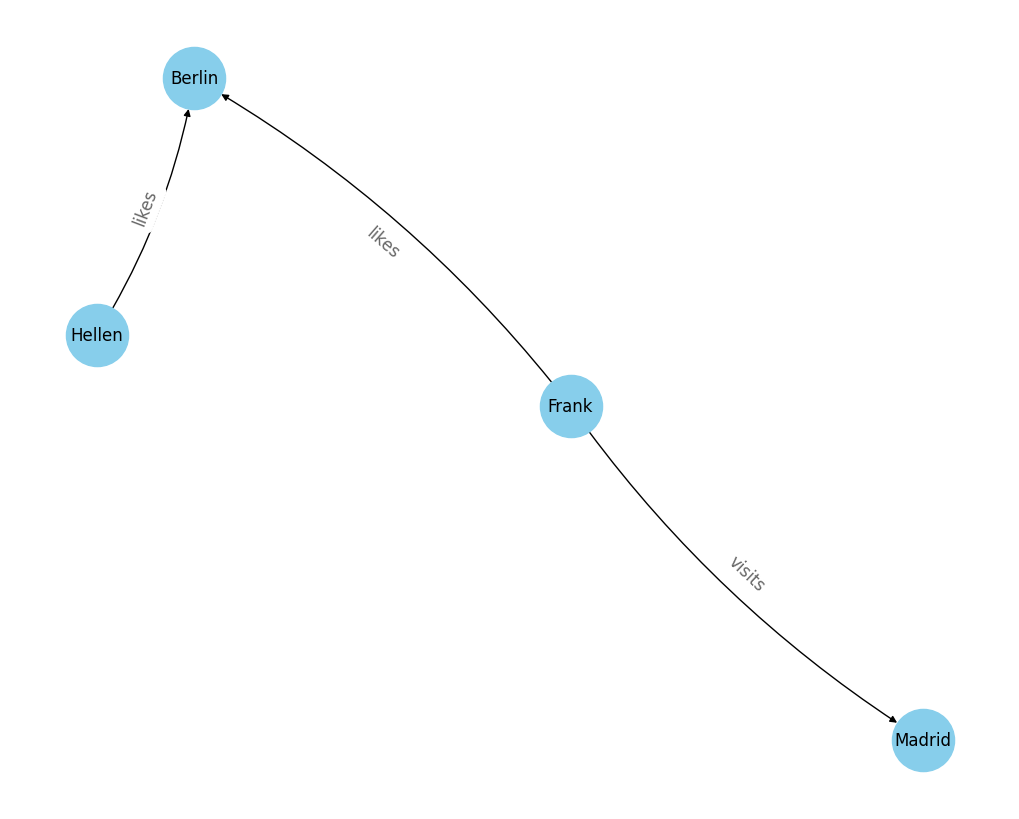

In [12]:
## create full graph
G = nx.from_pandas_edgelist(dtf, source="entity", target="object", 
                            edge_attr="relation", 
                            create_using=nx.DiGraph())


## plot
plt.figure(figsize=(10,8))

pos = nx.spring_layout(G, k=1)
node_color = "skyblue"
edge_color = "black"

nx.draw(G, pos=pos, with_labels=True, node_color=node_color, 
        edge_color=edge_color, cmap=plt.cm.Dark2, 
        node_size=2000, connectionstyle='arc3,rad=0.1')

nx.draw_networkx_edge_labels(G, pos=pos, label_pos=0.5, 
                         edge_labels=nx.get_edge_attributes(G,'relation'),
                         font_size=12, font_color='black', alpha=0.6)
plt.show()

Vamos a hacer pruebas para ver otras cosas.

In [13]:
sentence = "Tom goes to London"
doc = nlp(sentence)
dic2 = {"id":[], "text":[], "entity":[], "relation":[], "object":[]}
for token in doc: 
    match token.dep_:
        
        case "nsubj":
            dic2["entity"].append(token.text)
        case "pobj":
            dic2["object"].append(token.text)
        case "ROOT":                
            dic2["relation"].append(token.lemma_)
dic2
print(type(lst_docs))
for n,sentence in enumerate(lst_docs):
    print(f" n:{n} ; sentence: {sentence}; {type(sentence)}")
    

<class 'list'>
 n:0 ; sentence:  Peter travels to London.
        ; <class 'spacy.tokens.span.Span'>
 n:1 ; sentence: Frank likes Berlin.
        ; <class 'spacy.tokens.span.Span'>
 n:2 ; sentence: Marta goes to Paris.
        ; <class 'spacy.tokens.span.Span'>
 n:3 ; sentence: Frank visits Madrid.
        ; <class 'spacy.tokens.span.Span'>
 n:4 ; sentence: Kepa goes to Bilbao.
        ; <class 'spacy.tokens.span.Span'>
 n:5 ; sentence: Hellen likes Berlin.; <class 'spacy.tokens.span.Span'>


In [42]:
txt = """ Peter travels to London.
        Frank likes in Berlin.
        Marta goes to Paris.
        Frank visits to Madrid.
        Kepa goes to Bilbao.
        Hellen likes from Berlin.
        Peter goes to Paris."""
doc = nlp(txt)

lst_docs = [sent for sent in doc.sents]



## extract entities and relations
dic2 = {"id":[], "entity":[], "relation":[], "object":[]}

for n,sentence in enumerate(lst_docs):
    dic2["id"].append(n)
    for token in sentence: 
        match token.dep_:
            case "nsubj":
                dic2["entity"].append(token.text)
            case "pobj":
                dic2["object"].append(token.text)
            case "ROOT":
                dic2["relation"].append(token.lemma_)      
    
                                        
print(dic2)   
## create dataframe
dtf2 = pd.DataFrame(dic2)

dtf2


{'id': [0, 1, 2, 3, 4, 5, 6], 'entity': ['Peter', 'Frank', 'Marta', 'Frank', 'Kepa', 'Hellen', 'Peter'], 'relation': ['travel', 'like', 'go', 'visit', 'go', 'like', 'go'], 'object': ['London', 'Berlin', 'Paris', 'Madrid', 'Bilbao', 'Berlin', 'Paris']}


,id,entity,relation,object
0,0,Peter,travel,London
1,1,Frank,like,Berlin
2,2,Marta,go,Paris
3,3,Frank,visit,Madrid
4,4,Kepa,go,Bilbao
5,5,Hellen,like,Berlin
6,6,Peter,go,Paris


['Peter', 'London', 'Frank', 'Berlin', 'Marta', 'Paris', 'Madrid', 'Kepa', 'Bilbao', 'Hellen']
[('Peter', 'London'), ('Peter', 'Paris'), ('Frank', 'Berlin'), ('Frank', 'Madrid'), ('Marta', 'Paris'), ('Kepa', 'Bilbao'), ('Hellen', 'Berlin')]
['Peter', 'Peter', 'Frank', 'Frank', 'Marta', 'Kepa', 'Hellen']


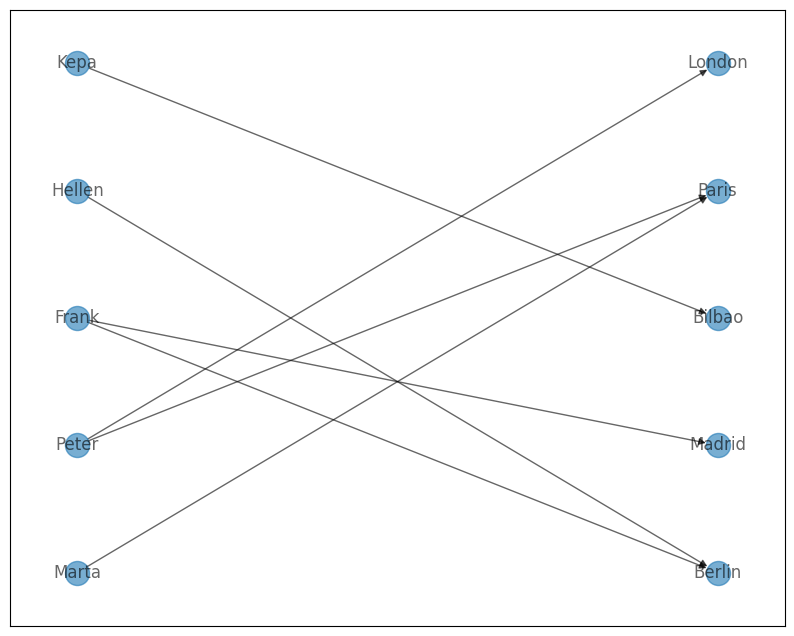

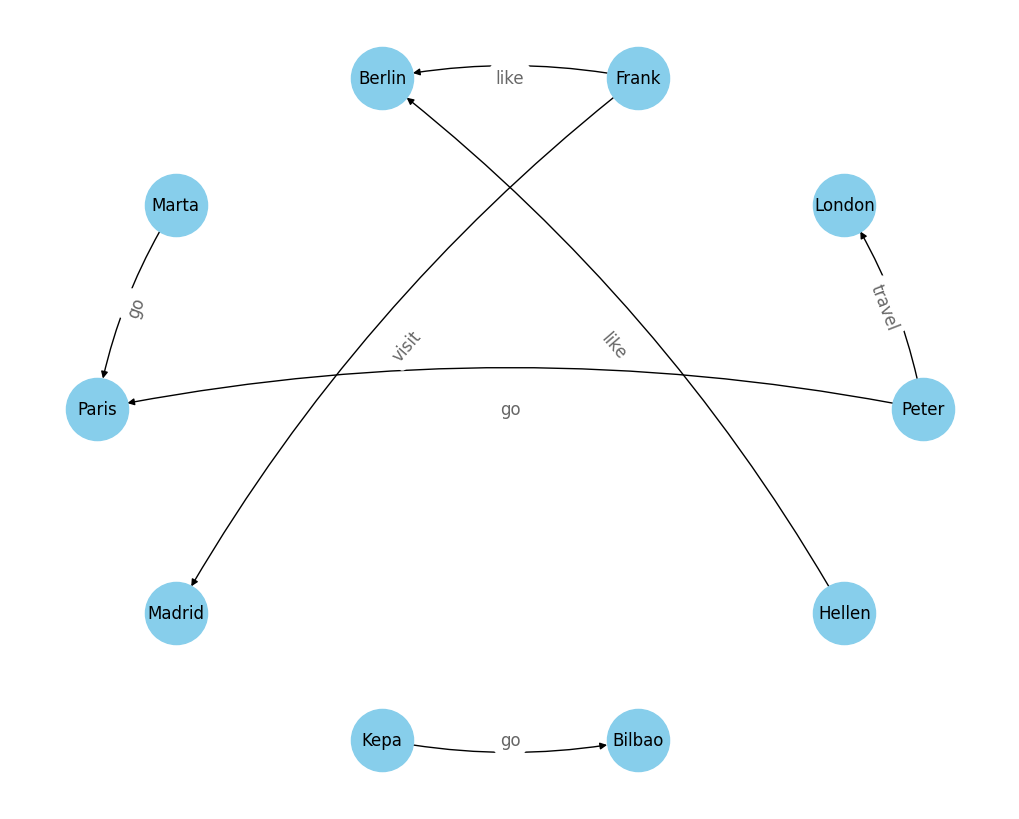

In [64]:
## create full graph
G = nx.from_pandas_edgelist(dtf2, source="entity", target="object", 
                            edge_attr="relation", 
                            create_using=nx.DiGraph())

# plot como grafo bipartito ( columna:personas  ; columna:ciudades)
print(G.nodes())
print(G.edges())
entity = [ ent for ent,obj in G.edges()]
print (entity)

from networkx.algorithms import bipartite
plt.figure(figsize=(10,8))
nx.draw_networkx(
    G,
    pos = nx.drawing.layout.bipartite_layout(G, entity),
    #label_pos=0.5, 
    #edge_labels=nx.get_edge_attributes(G,'relation'),
    font_size=12,
    font_color='black',
    alpha=0.6
)

## plot como lo hace el tutorial
plt.figure(figsize=(10,8))

pos = nx.circular_layout(G, )
node_color = "skyblue"
edge_color = "black"

nx.draw(G, pos=pos, with_labels=True, node_color=node_color, 
        edge_color=edge_color, cmap=plt.cm.Dark2, 
        node_size=2000, connectionstyle='arc3,rad=0.1')

nx.draw_networkx_edge_labels(G, pos=pos, label_pos=0.5, 
                         edge_labels=nx.get_edge_attributes(G,'relation'),
                         font_size=12, font_color='black', alpha=0.6)
plt.show()


/home/data/Documents/CursoIA/Jupiter/.Jupiter/lib/python3.10/site-packages/networkx/drawing/nx_pylab.py:304: UserWarning: 

The connectionstyle keyword argument is not applicable when drawing edges
with LineCollection.

To make this warning go away, either specify `arrows=True` to
force FancyArrowPatches or use the default value for connectionstyle.
Note that using FancyArrowPatches may be slow for large graphs.

  draw_networkx_edges(G, pos, arrows=arrows, **edge_kwds)


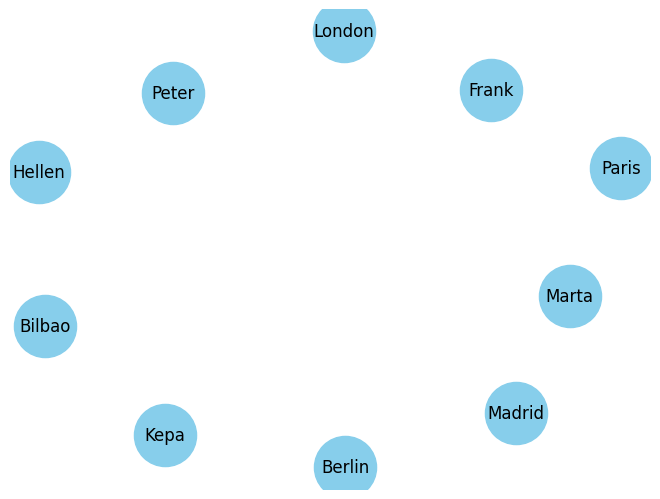

In [44]:
from networkx.algorithms import bipartite
B= nx.Graph()
B.add_nodes_from(dtf2['entity'], bipartite=0)
B.add_nodes_from(dtf2['object'], bipartite=1)

nx.draw(B,  with_labels=True, node_color=node_color, 
        edge_color=edge_color, cmap=plt.cm.Dark2, 
        node_size=2000, connectionstyle='arc3,rad=0.1')


plt.show()

In [48]:
G = nx.from_pandas_edgelist(dtf2, source="entity", target="object", 
                            edge_attr="relation", 
                            create_using=nx.DiGraph())



nx.draw_networkx(
    G,
    pos = nx.drawing.layout.bipartite_layout(G, )
) # O


TypeError: bipartite_layout() missing 1 required positional argument: 'nodes'

['Peter', 'Frank', 'Marta', 'Kepa', 'Hellen', 'London', 'Berlin', 'Paris', 'Madrid', 'Bilbao']
{'Marta', 'Peter', 'Frank', 'Hellen', 'Kepa'}
{'Berlin', 'Madrid', 'Bilbao', 'Paris', 'London'}
(('Marta', 'Berlin'), ('Peter', 'Madrid'), ('Frank', 'Bilbao'), ('Hellen', 'Paris'), ('Kepa', 'London'))


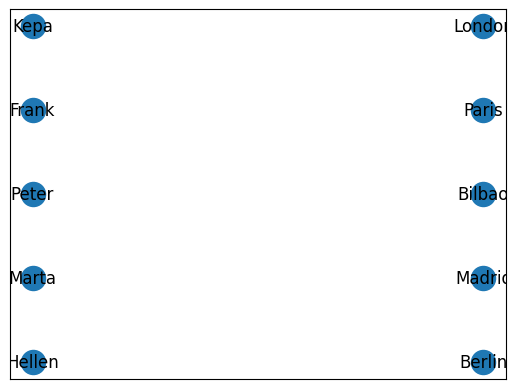

In [53]:
from networkx.algorithms import bipartite
NB= nx.Graph()
NB.add_nodes_from(dtf2['entity'], bipartite=0)
NB.add_nodes_from(dtf2['object'], bipartite=1)
print(NB.nodes())
source = {n for n, d in B.nodes(data=True) if d["bipartite"] == 0} 
target = set(NB) - source
print(source)
print(target)
edges = tuple(zip(source, target))
print(edges)


nx.draw_networkx(
    NB,
    pos = nx.drawing.layout.bipartite_layout(NB, source))


plt.show()


In [ ]:
G = nx.bipartite.gnmk_random_graph(3, 5, 10, seed=123)
top = nx.bipartite.sets(G)[0]
pos = nx.bipartite_layout(G, top)

In [35]:
B = nx.Graph()
# Add nodes with the node attribute "bipartite"
B.add_nodes_from([1, 2, 3, 4], bipartite=0)
B.add_nodes_from(["a", "b", "c"], bipartite=1)
# Add edges only between nodes of opposite node sets
B.add_edges_from([(1, "a"), (1, "b"), (2, "b"), (2, "c"), (3, "c"), (4, "a")])
print(B.nodes())

[1, 2, 3, 4, 'a', 'b', 'c']


In [37]:
nx.is_connected(B)
bottom_nodes, top_nodes = bipartite.sets(B)